# Task 2: Setup

In [ ]:
!pip install -q pydub

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [ ]:
dataset = tfds.load("gtzan_music_speech")

Shuffling and writing examples to /root/tensorflow_datasets/gtzan_music_speech/1.0.0.incompleteEFT9SI/gtzan_music_speech-train.tfrecord


Dataset gtzan_music_speech downloaded and prepared to /root/tensorflow_datasets/gtzan_music_speech/1.0.0. Subsequent calls will reuse this data.


# Task 3: Explore the Data

In [ ]:
# There is no explicit validation set. That will be done later
train = dataset["train"]

data_iter = iter(train)

In [ ]:
# Take a look at an example
example = next(data_iter)
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [ ]:
audio = example.get("audio")
label = example.get("label")

print(label.numpy())
Audio(audio, rate = 22050)

0


In [ ]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [ ]:
print(audio.shape)

(661500,)


In [ ]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

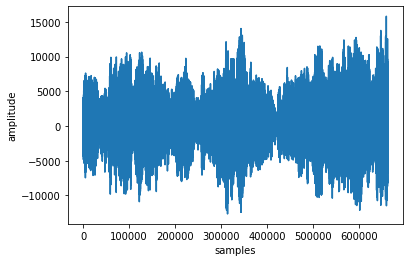

In [ ]:
plot_waveform(audio)

# Task 4: Spectrogram

In [ ]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [ ]:
audio_stft = get_stft(audio)
audio_spec = tf.abs(audio_stft)

In [ ]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

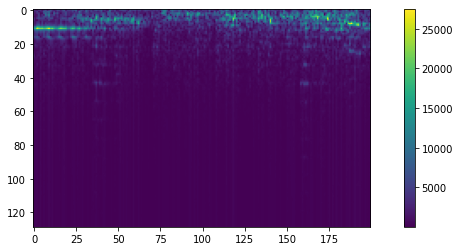

In [ ]:
plot_spec(audio_spec[:200])

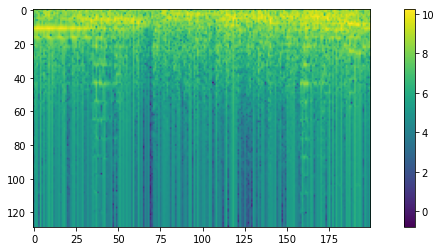

In [ ]:
audio_spec_log = tf.math.log(audio_spec)

plot_spec(audio_spec_log[:200])

In [ ]:
def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Task 5: Prepare the Data

In [ ]:
sr = 22050 # samples per second
chunk_len = 5 # seconds

def preprocess_example(example):
  audio = example.get("audio")
  label = example.get("label")
  
  x_batch, y_batch = None, None

  for i in range(0,6):
    start_sample = i*chunk_len*sr
    end_sample = (i+1)*chunk_len*sr
    audio_chunk = audio[start_sample:end_sample]
    audio_spec = get_spectrogram(audio_chunk)
    audio_chunk = tf.expand_dims(audio_spec, axis =0)
    current_label = tf.expand_dims(label, axis = 0)

    x_batch = audio_spec if x_batch is None else tf.concat([x_batch, audio_spec], axis = 0)
    y_batch = current_label if y_batch is None else tf.concat([y_batch, current_label], axis =0)
  return x_batch, y_batch




In [ ]:
x_train, y_train = None, None,

for example in tqdm(iter(train)):
  x_batch, y_batch = preprocess_example(example)

  x_train = x_batch if x_train is None else tf.concat([x_train, x_batch], axis = 0)
  y_train = y_batch if y_train is None else tf.concat([y_train, y_batch], axis = 0)

128it [00:04, 26.51it/s]


In [ ]:
x_train = tf.reshape(x_train, [768,129,212]).numpy()

In [ ]:
print(x_train.shape,y_train.shape)

(768, 129, 212) (768,)


In [ ]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

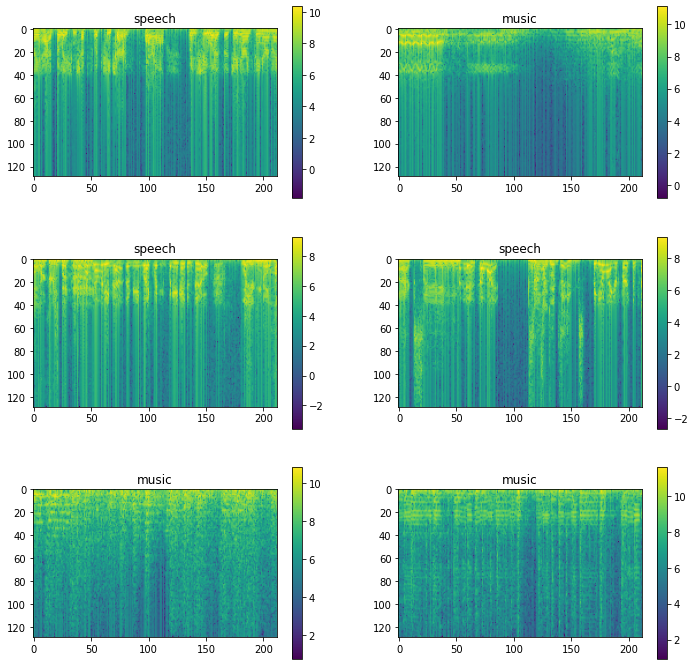

In [ ]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Task 6: Create the Model

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense

In [ ]:
input_ = Input(shape = (129,212))
x = Lambda(lambda x : tf.expand_dims(x, axis = -1))(input_)


for i in range (0,4):
  num_filters = 2**(5 + i)
  x = Conv2D(num_filters,3)(x)
  x = BatchNormalization()(x)
  x = Activation("tanh")(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(input_,x)

In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-6),  # starting with a low learning rate
    metrics = ["accuracy"]
)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 127, 210, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 103, 64)       1849

# Task 7: Model Training

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [ ]:
_ = model.fit(
    x_train , y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 12,
    epochs = 500,
    verbose = True,
    callbacks = [CustomCallback()]

)

Epoch 1/500
 4/39 [==>...........................] - ETA: 0s - loss: 0.7285 - accuracy: 0.5625   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_train_batch_end` time: 0.0106s). Check your callbacks.


39/39 [==============================] - 33s 25ms/step - loss: 0.7729 - accuracy: 0.5577 - val_loss: 0.7644 - val_accuracy: 0.4800
Epoch 2/500
39/39 [==============================] - 1s 19ms/step - loss: 0.7037 - accuracy: 0.6132 - val_loss: 0.8313 - val_accuracy: 0.4800
Epoch 3/500
39/39 [==============================] - 1s 19ms/step - loss: 0.6347 - accuracy: 0.6624 - val_loss: 0.8330 - val_accuracy: 0.5067
Epoch 4/500
39/39 [==============================] - 1s 19ms/step - loss: 0.6211 - accuracy: 0.6795 - val_loss: 0.7874 - val_accuracy: 0.5367
Epoch 5/500
39/39 [==============================] - 1s 20ms/step - loss: 0.5823 - accuracy: 0.6966 - val_loss: 0.7021 - val_accuracy: 0.5967
Epoch:   4, Loss: 0.5823, Acc: 0.6966, Val Loss: 0.7021, Val Acc: 0.5967
Epoch 6/500
39/39 [==============================] - 1s 19ms/step - loss: 0.5602 - accuracy: 0.7030 - val_loss: 0.6329 - val_accuracy: 0.6367
Epoch 7/500
39/39 [==============================] - 1s 20ms/step - loss: 0.5285 - acc

# Task 8: Predictions

In [ ]:
example = next(data_iter)

x_test, y_test = preprocess_example(example)
x_test = tf.reshape(x_test, [6,129,212]).numpy()
preds = model.predict(x_test)
pred_classes = tf.squeeze(tf.cast(preds > 0.5, tf.int8))

In [ ]:
pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [ ]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>